<a href="https://colab.research.google.com/github/AdidasSuperstar/detr/blob/master/Object_detection_DETR_sugar_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
! pip install GPutil

  Created wheel for GPutil: filename=GPUtil-1.4.0-cp37-none-any.whl size=7411 sha256=1fd6ff78170ded5aff94408927ff9ea5c5a45e270782b1f8a103f88dded3a786
  Stored in directory: /root/.cache/pip/wheels/3d/77/07/80562de4bb0786e5ea186911a2c831fdd0018bda69beab71fd
Successfully built GPutil


In [1]:
# Mount your google drive in google colab
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Insert the directory
import sys
sys.path.insert(0,'/content/My Drive/detr')

In [3]:
! pwd

/content


In [4]:
%cd '/content/drive/My Drive/detr'


/content/drive/My Drive/detr


In [ ]:
! pwd

/content/drive/My Drive/detr


In [8]:
# Torch
import torch
import torch.nn as nn
from torch.utils.data import Dataset,DataLoader
from torch.utils.data.sampler import SequentialSampler, RandomSampler

import GPUtil
import os
print("My working directory is: " , os.getcwd())


from models.matcher import HungarianMatcher
from models.detr import SetCriterion

import numpy as np
import pandas as pd
from datetime import datetime
import time
import random

from tqdm import tqdm

#sklearn
from sklearn.model_selection import StratifiedKFold

#CV
import cv2

#matplotlib
import matplotlib.pyplot as plt

#albumentations
# import albumentations as A
# not working in colab 
# from albumentations.pytorch.transforms import ToTensorV2

#Glob
from glob import glob

My working directory is:  /content/drive/My Drive/detr


In [6]:
! pip install albumentations==0.4.6

     |████████████████████████████████| 122kB 7.6MB/s 
     |████████████████████████████████| 952kB 13.0MB/s 
  Created wheel for albumentations: filename=albumentations-0.4.6-cp37-none-any.whl size=65175 sha256=c455c6ec60da5afcaa5763b909e6d119e2a399ee6fbaeae22b6bf02b330b01d7
  Stored in directory: /root/.cache/pip/wheels/c7/f4/89/56d1bee5c421c36c1a951eeb4adcc32fbb82f5344c086efa14
Successfully built albumentations
  Found existing installation: imgaug 0.2.9
    Uninstalling imgaug-0.2.9:
      Successfully uninstalled imgaug-0.2.9
  Found existing installation: albumentations 0.1.12
    Uninstalling albumentations-0.1.12:
      Successfully uninstalled albumentations-0.1.12


In [7]:
#albumentations
import albumentations as A
# not working in colab 
from albumentations.pytorch.transforms import ToTensorV2

In [10]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

### CONFIGURATION -- Basic configuration for this model
n_folds = 3
seed = 42
num_classes = 2 #changed this 
num_queries = 100
null_class_coef = 0.5
BATCH_SIZE = 2 #8
LR = 2e-5
EPOCHS = 2 #2

### SEED - for reproducible results
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(seed)

In [12]:
marking = pd.read_csv('/content/drive/My Drive/detr/Sugar_Dataset_f1_June8_920_final.csv')
marking.columns
marking.shape
marking.head()

,Unnamed: 0,bbox,image_id,category,name
0,0,"[534, 593, 148, 130]",0,1,bonirob_2016-05-23-10-37-10_0_frame100
1,1,"[531, 1, 225, 204]",0,1,bonirob_2016-05-23-10-37-10_0_frame100
2,2,"[501, 753, 224, 206]",1,1,bonirob_2016-05-23-10-37-10_0_frame101
3,3,"[586, 353, 251, 328]",2,1,bonirob_2016-05-23-10-37-10_0_frame102
4,4,"[492, 1, 229, 131]",2,1,bonirob_2016-05-23-10-37-10_0_frame102


In [13]:
marking['image_id'].nunique()

921

In [15]:
### DATA PREP
marking = pd.read_csv('/content/drive/My Drive/detr/Sugar_Dataset_f1_June8_920_final.csv')

bboxs = np.stack(marking['bbox'].apply(lambda x: np.fromstring(x[1:-1], sep=',')))
for i, column in enumerate(['x', 'y', 'w', 'h']):
    marking[column] = bboxs[:,i]
marking.drop(columns=['bbox'], inplace=True)

# Creating Folds
skf = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=seed)

df_folds = marking[['name']].copy()
df_folds.loc[:, 'bbox_count'] = 1
df_folds = df_folds.groupby('name').count()
df_folds.loc[:, 'source'] = marking[['name', 'category']].groupby('name').min()['category']
df_folds.loc[:, 'stratify_group'] = np.char.add(
    df_folds['source'].values.astype(str),
    df_folds['bbox_count'].apply(lambda x: f'_{x // 15}').values.astype(str)
)
df_folds.loc[:, 'fold'] = 0

for fold_number, (train_index, val_index) in enumerate(skf.split(X=df_folds.index, y=df_folds['stratify_group'])):
    df_folds.loc[df_folds.iloc[val_index].index, 'fold'] = fold_number

#print(n_folds) #5
#print(fold_number) #4 #what is this? Really?? Just a column in the bloody dataset??!
#print(df_folds.head())

#check GPU utilization
#GPUtil.showUtilization()

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  % (min_groups, self.n_splits)), UserWarning)


In [ ]:
df_folds.head()

,bbox_count,source,stratify_group,fold
name,,,,
sugar_f1_170912_01_subImages_2_frame100__0_ulr0_ulc0.png,18,1,1_1,1
sugar_f1_170912_01_subImages_2_frame100__10_ulr768_ulc0.png,27,1,1_1,0
sugar_f1_170912_01_subImages_2_frame100__11_ulr768_ulc512.png,25,1,1_1,1
sugar_f1_170912_01_subImages_2_frame100__12_ulr768_ulc1024.png,20,1,1_1,2
sugar_f1_170912_01_subImages_2_frame100__13_ulr768_ulc1536.png,20,1,1_1,1


In [ ]:
df_folds.shape

(400, 4)

In [16]:
###AUGMENTATIONS
def get_train_transforms():
    return A.Compose(
        [A.OneOf([A.HueSaturationValue(hue_shift_limit=0.2, sat_shift_limit=0.2, val_shift_limit=0.2, p=0.9),

                  A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.9)], p=0.9),

         A.ToGray(p=0.01),

         A.HorizontalFlip(p=0.5),

         A.VerticalFlip(p=0.5),

         A.Resize(height=256, width=256, p=1), #height 512, width 512 

         A.Cutout(num_holes=8, max_h_size=64, max_w_size=64, fill_value=0, p=0.5),

         ToTensorV2(p=1.0)],

        p=1.0,

        bbox_params=A.BboxParams(format='coco', min_area=0, min_visibility=0, label_fields=['labels'])
        )


def get_valid_transforms():
    return A.Compose([
                      A.Resize(height=512, width=512, p=1.0),
                      ToTensorV2(p=1.0)],
                     p=1.0,
                     bbox_params=A.BboxParams(format='coco', min_area=0, min_visibility=0, label_fields=['labels'])
                     )

print ("So far so good") #A.Resize(height=512, width=512, p=1.0),
###CREATE DATASET
DIR_TRAIN = "/content/drive/My Drive/detr/models/F1_minus_60" #1361 images


So far so good


In [17]:
import fnmatch

In [18]:
def filter_for_png(root, files):
    return [path for path in (os.path.join(root, f) for f in files) if fnmatch.fnmatch(path, "*.png")]

#get files names
for root, _, files in os.walk(DIR_TRAIN):
    image_files_EVA = filter_for_png(root, files)

print(len(image_files_EVA))


921


In [ ]:
def filter_for_png2(root, files):
    return [path for path in (os.path.join(root, f) for f in files) if fnmatch.fnmatch(path, "*.PNG")]

#get files names
for root, _, files in os.walk(DIR_TRAIN):
    image_files_EVA2 = filter_for_png2(root, files)

print(len(image_files_EVA2))


0


In [ ]:
print(image_files_EVA[-1])

/content/drive/My Drive/detr/models/rgb/bonirob_2016-05-23-10-52-28_3_frame94.png


In [ ]:
my_img = cv2.imread("/content/drive/My Drive/detr/models/rgb2/sugar_f1_170912_01_subImages_2_frame80__10_ulr768_ulc0.png")
my_img = cv2.cvtColor(my_img, cv2.COLOR_BGR2RGB).astype(np.float32)
#plt.imshow(my_img)

print(my_img)
print(type(my_img))
print(my_img.shape) #(966, 1296, 3) and (384,512,3) for 2nd folder

[[[192. 168. 134.]
  [187. 163. 130.]
  [194. 170. 136.]
  ...
  [ 82.  65.  22.]
  [122.  99.  58.]
  [166. 140. 104.]]

 [[173. 148. 117.]
  [190. 165. 134.]
  [193. 168. 138.]
  ...
  [103.  84.  43.]
  [157. 135.  96.]
  [187. 163. 126.]]

 [[168. 143. 113.]
  [192. 167. 136.]
  [205. 180. 149.]
  ...
  [138. 119.  79.]
  [173. 151. 112.]
  [182. 161. 123.]]

 ...

 [[211. 215. 167.]
  [188. 193. 143.]
  [173. 182. 129.]
  ...
  [134. 107.  79.]
  [133. 106.  78.]
  [124.  97.  69.]]

 [[193. 196. 147.]
  [177. 183. 132.]
  [173. 181. 127.]
  ...
  [125.  98.  71.]
  [127. 100.  73.]
  [129. 102.  75.]]

 [[177. 184. 131.]
  [177. 184. 131.]
  [174. 185. 127.]
  ...
  [121.  94.  67.]
  [127. 100.  73.]
  [138. 111.  84.]]]
<class 'numpy.ndarray'>
(384, 512, 3)


In [19]:
class WheatDataset(Dataset):
    def __init__(self, image_ids, dataframe, transforms=None):
        self.image_ids = image_ids
        self.df = dataframe
        self.transforms = transforms

    def __len__(self) -> int:
        return self.image_ids.shape[0]

    def __getitem__(self, index):
        image_id = self.image_ids[index]
        records = self.df[self.df['name'] == image_id]
        
        image = cv2.imread(f'{DIR_TRAIN}/{image_id}.png') #, cv2.IMREAD_COLOR
        if image is not None:
          image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
          image /= 255.0

          # DETR takes in data in coco format
          boxes = records[['x', 'y', 'w', 'h']].values

          # Area of bb
          area = boxes[:, 2] * boxes[:, 3]
          area = torch.as_tensor(area, dtype=torch.float32)

         # AS pointed out by PRVI It works better if the main class is labelled as zero
          labels = np.zeros(len(boxes), dtype=np.int32)

          if self.transforms:
            sample = {
                'image': image,
                'bboxes': boxes,
                'labels': labels
            }
            sample = self.transforms(**sample)
            image = sample['image']
            boxes = sample['bboxes']
            labels = sample['labels']

        # Normalizing BBOXES

          _, h, w = image.shape
          boxes = A.augmentations.bbox_utils.normalize_bboxes(sample['bboxes'], rows=h, cols=w)
          target = {}
          target['boxes'] = torch.as_tensor(boxes, dtype=torch.float32)
          target['labels'] = torch.as_tensor(labels, dtype=torch.long)
          target['image_id'] = torch.tensor([index])
          target['area'] = area

          return image, target, image_id

print("So far so good  - part 2")

#check GPU utilization
#GPUtil.showUtilization()

So far so good  - part 2


In [20]:
###MODEL
class DETRModel(nn.Module):
    def __init__(self, num_classes, num_queries):
        super(DETRModel, self).__init__()
        self.num_classes = num_classes
        self.num_queries = num_queries

        self.model = torch.hub.load('facebookresearch/detr', 'detr_resnet50', pretrained=True)
        self.in_features = self.model.class_embed.in_features

        self.model.class_embed = nn.Linear(in_features=self.in_features, out_features=self.num_classes)
        self.model.num_queries = self.num_queries

    def forward(self, images):
        return self.model(images)

In [ ]:
from models.matcher import HungarianMatcher

In [21]:
###Matcher and Bipartite Matching Loss
'''
code taken from github repo detr , 'code present in engine.py'
'''

matcher = HungarianMatcher()

weight_dict = weight_dict = {'loss_ce': 1, 'loss_bbox': 1 , 'loss_giou': 1}

losses = ['labels', 'boxes', 'cardinality']

In [22]:
### Training Function
def train_fn(data_loader, model, criterion, optimizer, device, scheduler, epoch):
    model.train()
    criterion.train()

    summary_loss = AverageMeter()

    tk0 = tqdm(data_loader, total=len(data_loader))

    for step, (images, targets, image_ids) in enumerate(tk0):

        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        output = model(images)

        loss_dict = criterion(output, targets)
        weight_dict = criterion.weight_dict

        losses = sum(loss_dict[k] * weight_dict[k] for k in loss_dict.keys() if k in weight_dict)

        optimizer.zero_grad()

        losses.backward()
        optimizer.step()
        if scheduler is not None:
            scheduler.step()

        summary_loss.update(losses.item(), BATCH_SIZE)
        tk0.set_postfix(loss=summary_loss.avg)

    return summary_loss

In [23]:
def eval_fn(data_loader, model,criterion, device):
    model.eval()
    criterion.eval()
    summary_loss = AverageMeter()
    
    with torch.no_grad():
        
        tk0 = tqdm(data_loader, total=len(data_loader))
        for step, (images, targets, image_ids) in enumerate(tk0):
            
            images = list(image.to(device) for image in images)
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

            output = model(images)
        
            loss_dict = criterion(output, targets)
            weight_dict = criterion.weight_dict
        
            losses = sum(loss_dict[k] * weight_dict[k] for k in loss_dict.keys() if k in weight_dict)
            
            summary_loss.update(losses.item(),BATCH_SIZE)
            tk0.set_postfix(loss=summary_loss.avg)
    
    return summary_loss

In [24]:
### Engine
def collate_fn(batch):
    return tuple(zip(*batch))

#check GPU utilization
#GPUtil.showUtilization()

In [ ]:
df_tr = df_folds[df_folds['fold'] != 0]
  

#train_dataset = WheatDataset(image_ids=df_train.index.values, dataframe=marking, transforms=get_train_transforms())

#print(type(train_dataset))

In [ ]:
df_tr.tail()

,bbox_count,source,stratify_group,fold
name,,,,
sugar_f1_170912_01_subImages_2_frame90__4_ulr0_ulc2048,13,1,1_0,2
sugar_f1_170912_01_subImages_2_frame90__5_ulr384_ulc0,16,1,1_1,4
sugar_f1_170912_01_subImages_2_frame90__6_ulr384_ulc512,11,1,1_0,3
sugar_f1_170912_01_subImages_2_frame90__7_ulr384_ulc1024,20,1,1_1,4
sugar_f1_170912_01_subImages_2_frame90__9_ulr384_ulc2048,22,1,1_1,4


In [25]:
def run(fold):
    df_train = df_folds[df_folds['fold'] != fold]
    df_valid = df_folds[df_folds['fold'] == fold]

    train_dataset = WheatDataset(
        image_ids=df_train.index.values,
        dataframe=marking,
        transforms=get_train_transforms()
    )

    valid_dataset = WheatDataset(
        image_ids=df_valid.index.values,
        dataframe=marking,
        transforms=get_valid_transforms()
    )

    train_data_loader = DataLoader(
        train_dataset,
        batch_size=BATCH_SIZE,
        shuffle=False,
        num_workers=1, #1
        collate_fn=collate_fn
    )

    valid_data_loader = DataLoader(
        valid_dataset,
        batch_size=BATCH_SIZE,
        shuffle=False,
        num_workers=1, #1
        collate_fn=collate_fn
    )

    device = torch.device('cuda:0')
    model = DETRModel(num_classes=num_classes, num_queries=num_queries)
    model = model.to(device)
    criterion = SetCriterion(num_classes - 1, matcher, weight_dict, eos_coef=null_class_coef, losses=losses)
    criterion = criterion.to(device)

    optimizer = torch.optim.AdamW(model.parameters(), lr=LR)

    best_loss = 10 ** 5
    for epoch in range(EPOCHS):
        train_loss = train_fn(train_data_loader, model, criterion, optimizer, device, scheduler=None, epoch=epoch)
        valid_loss = eval_fn(valid_data_loader, model, criterion, device)

        print('|EPOCH {}| TRAIN_LOSS {}| VALID_LOSS {}|'.format(epoch + 1, train_loss.avg, valid_loss.avg))

        if valid_loss.avg < best_loss:
            best_loss = valid_loss.avg
            print('Best model sugar found for Fold {} in Epoch {}........Saving Model'.format(fold, epoch + 1))
            torch.save(model.state_dict(), f'detr_best_{fold}.pth')



In [26]:
run(fold=0)
# model = run(fold=0)
# model.cuda()



Downloading: "https://github.com/facebookresearch/detr/archive/master.zip" to /root/.cache/torch/hub/master.zip
Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth


Downloading: "https://dl.fbaipublicfiles.com/detr/detr-r50-e632da11.pth" to /root/.cache/torch/hub/checkpoints/detr-r50-e632da11.pth


100%|██████████| 154/154 [03:55<00:00,  1.53s/it, loss=1.85]


|EPOCH 1| TRAIN_LOSS 1.885093492483083| VALID_LOSS 1.8523416751390929|
Best model sugar found for Fold 0 in Epoch 1........Saving Model


100%|██████████| 154/154 [00:16<00:00,  9.40it/s, loss=1.92]

|EPOCH 2| TRAIN_LOSS 1.8129677368685944| VALID_LOSS 1.9171111630154896|


In [27]:
def view_sample(df_valid, model):
    '''
    Code taken from Peter's Kernel
    https://www.kaggle.com/pestipeti/pytorch-starter-fasterrcnn-train
    '''
    valid_dataset = WheatDataset(image_ids=df_valid.index.values,
                                 dataframe=marking,
                                 transforms=get_valid_transforms()
                                 )

    valid_data_loader = DataLoader(
        valid_dataset,
        batch_size=BATCH_SIZE,
        shuffle=False,
        num_workers=1,
        collate_fn=collate_fn)

    images, targets, image_ids = next(iter(valid_data_loader))
    _, h, w = images[0].shape  # for de normalizing images

    #images = list(img.to(device) for img in images)
    #targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

    images = list(img for img in images)
    targets = [{k: v for k, v in t.items()} for t in targets]

    boxes = targets[0]['boxes'].cpu().numpy()
    boxes = [np.array(box).astype(np.int32) for box in A.augmentations.bbox_utils.denormalize_bboxes(boxes, h, w)]
    sample = images[0].permute(1, 2, 0).cpu().numpy()

    model.eval()
    #model.to(device)
    #cpu_device = torch.device("cpu")

    with torch.no_grad():
        outputs = model(images)

    outputs = [{k: v for k, v in outputs.items()}]

    fig, ax = plt.subplots(1, 1, figsize=(16, 8))

    #real data is red
    for box in boxes:
        cv2.rectangle(sample,
                      (box[0], box[1]),
                      (box[2] + box[0], box[3] + box[1]),
                      (220, 0, 0), 1)

    #oboxes = outputs[0]['pred_boxes'][0].detach().cpu().numpy()
    oboxes = outputs[0]['pred_boxes'][0].detach().numpy()
    oboxes = [np.array(box).astype(np.int32) for box in A.augmentations.bbox_utils.denormalize_bboxes(oboxes, h, w)]
    #prob = outputs[0]['pred_logits'][0].softmax(1).detach().cpu().numpy()[:, 0]
    prob = outputs[0]['pred_logits'][0].softmax(1).detach().numpy()[:, 0]

    # predictions are blue 
    for box, p in zip(oboxes, prob):

        if p > 0.5:
            # color = (0, 0, 220)
            color = (255, 255, 0)  # if p>0.5 else (0,0,0)
            cv2.rectangle(sample,
                          (box[0], box[1]),
                          (box[2] + box[0], box[3] + box[1]),
                          color, 1)

    ax.set_axis_off()
    ax.imshow(sample)
    #ax.imshow((sample * 255).astype(np.uint8))
    # fig.show() -- this plus edited ax.imshow shows image, but no bounding boxes
    # plt.imshow((out * 255).astype(np.uint8))




Using cache found in /root/.cache/torch/hub/facebookresearch_detr_master
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


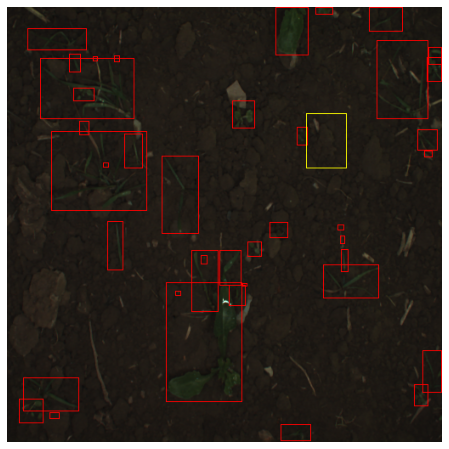

In [28]:
model = DETRModel(num_classes=num_classes,num_queries=num_queries)
model.load_state_dict(torch.load("./detr_best_0.pth"))
view_sample(df_folds[df_folds['fold'] == 0],model=model)